In [15]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [16]:
log_dir = "../logs"

In [17]:
log_files = {}
for fname in os.listdir(log_dir):
    if fname.startswith("fix_") and fname.endswith(".log"):
        strat_name = fname[len("fix_") : -len(".log")]
        log_files[strat_name] = os.path.join(log_dir, fname)

In [18]:
trade_rows = []
fill_pattern = re.compile(r"OUT: (.*)")

in_pattern = re.compile(r"IN: (.*)")

In [19]:
for strat, fname in log_files.items():
    with open(fname, "r") as f:
        for line in f:
            # Parse fills (ExecutionReport 35=8)
            m = fill_pattern.search(line)
            if m and "35=8" in m.group(1):
                fields = {
                    kv.split("=")[0]: kv.split("=")[1]
                    for kv in m.group(1).split("|")
                    if "=" in kv
                }
                trade_rows.append(
                    {
                        "strategy": fields.get("6007", strat),
                        "symbol": fields.get("55", None),
                        "qty": int(fields.get("32", 0)),
                        "price": float(fields.get("31", 0)),
                        "side": fields.get("54", None),
                        "timestamp": fields.get("52", None),  # FIX 52 is sending time
                        "order_id": fields.get(
                            "11", None
                        ),  # ClOrdID for possible latency calculation
                    }
                )

In [20]:
df_trades = pd.DataFrame(trade_rows)

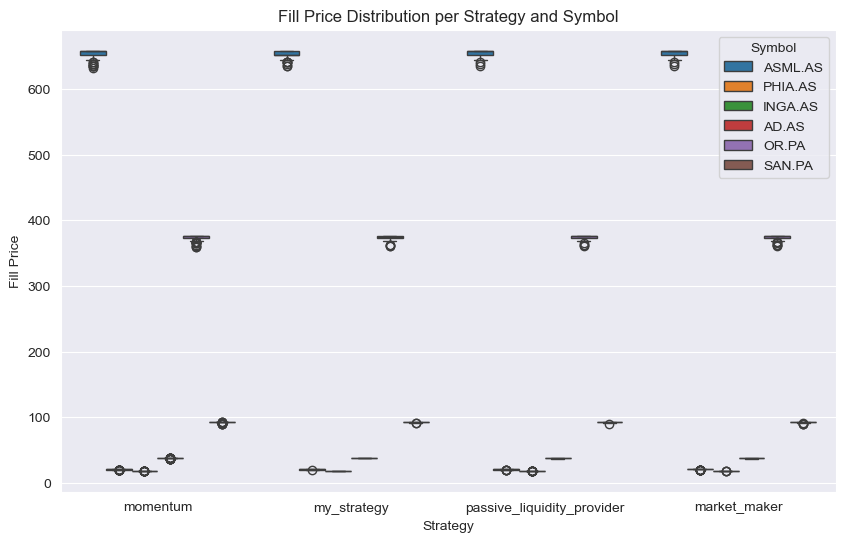

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_trades, x="strategy", y="price", hue="symbol")
plt.title("Fill Price Distribution per Strategy and Symbol")
plt.ylabel("Fill Price")
plt.xlabel("Strategy")
plt.legend(title="Symbol")
plt.show()

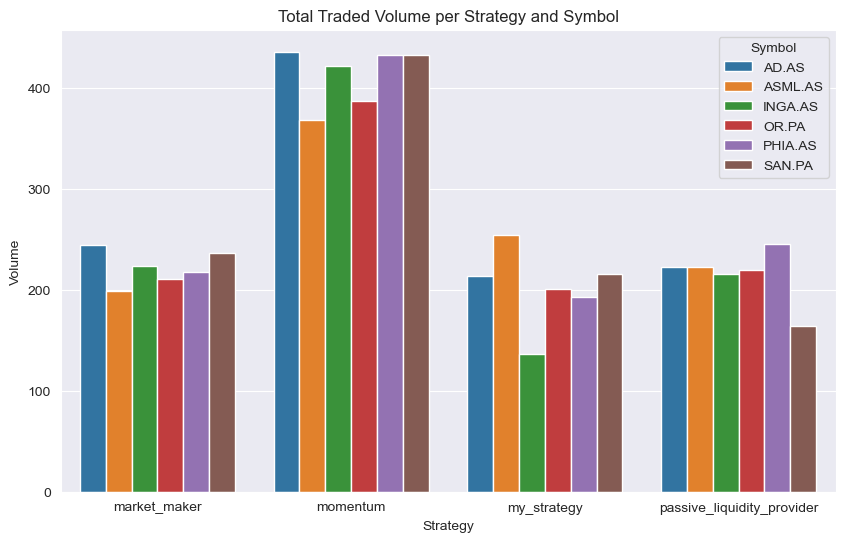

In [22]:
volume = df_trades.groupby(["strategy", "symbol"])["qty"].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=volume, x="strategy", y="qty", hue="symbol")
plt.title("Total Traded Volume per Strategy and Symbol")
plt.ylabel("Volume")
plt.xlabel("Strategy")
plt.legend(title="Symbol")
plt.show()

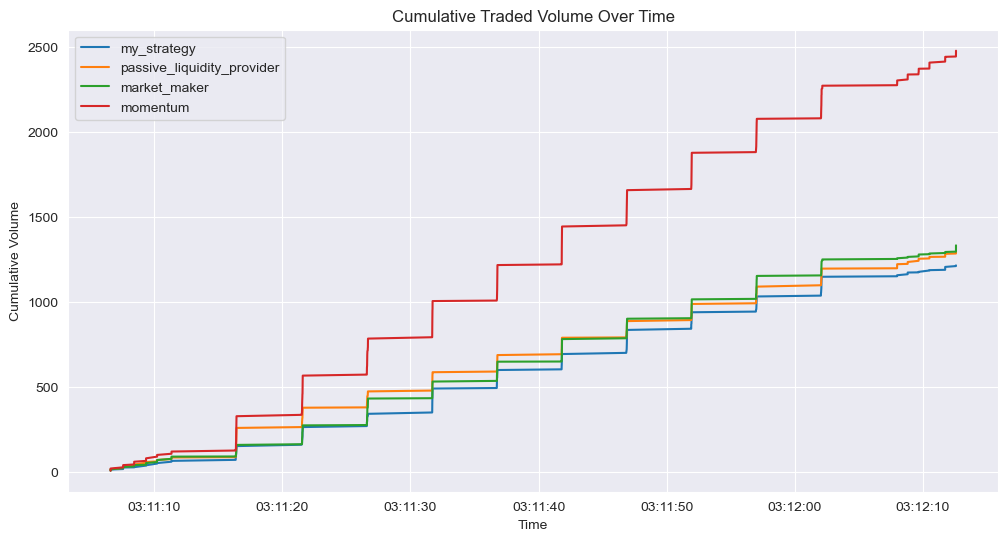

In [23]:
df_trades["timestamp"] = pd.to_datetime(df_trades["timestamp"], errors="coerce")
df_trades = df_trades.sort_values("timestamp")
df_trades["cum_qty"] = df_trades.groupby("strategy")["qty"].cumsum()
plt.figure(figsize=(12, 6))
for strat in df_trades["strategy"].unique():
    plt.plot(
        df_trades[df_trades["strategy"] == strat]["timestamp"],
        df_trades[df_trades["strategy"] == strat]["cum_qty"],
        label=strat,
    )
plt.title("Cumulative Traded Volume Over Time")
plt.ylabel("Cumulative Volume")
plt.xlabel("Time")
plt.legend()
plt.show()

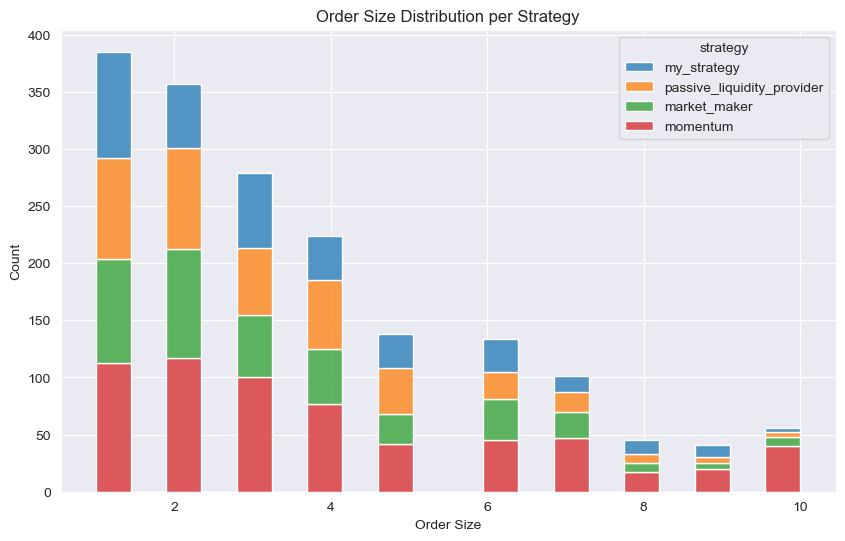

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_trades, x="qty", hue="strategy", multiple="stack", bins=20)
plt.title("Order Size Distribution per Strategy")
plt.xlabel("Order Size")
plt.ylabel("Count")
plt.show()

In [25]:
pnl_rows = []
for strat in df_trades["strategy"].unique():
    strat_trades = df_trades[df_trades["strategy"] == strat].sort_values("timestamp")
    position = 0
    cash = 0.0
    for _, row in strat_trades.iterrows():
        qty = row["qty"]
        price = row["price"]
        if row["side"] == "1":  # Buy
            position += qty
            cash -= qty * price
        elif row["side"] == "2":  # Sell
            position -= qty
            cash += qty * price
    # Approximate PnL: cash + value of remaining position at last price
    last_price = strat_trades["price"].iloc[-1] if not strat_trades.empty else 0
    pnl = cash + position * last_price
    pnl_rows.append({"strategy": strat, "pnl_proxy": pnl})

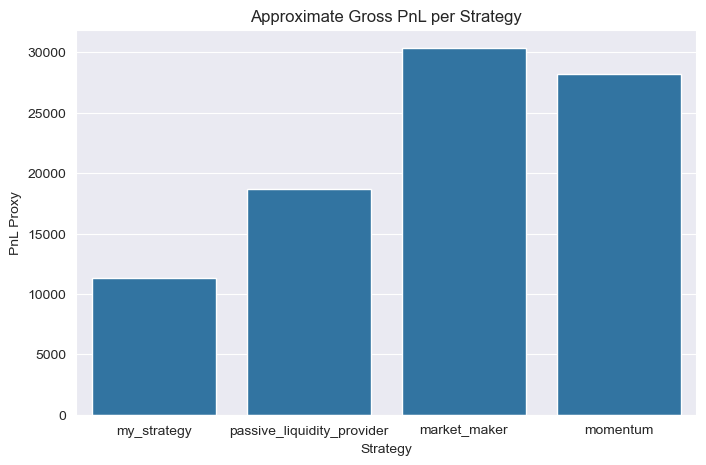

In [26]:
df_pnl = pd.DataFrame(pnl_rows)
plt.figure(figsize=(8, 5))
sns.barplot(data=df_pnl, x="strategy", y="pnl_proxy")
plt.title("Approximate Gross PnL per Strategy")
plt.ylabel("PnL Proxy")
plt.xlabel("Strategy")
plt.show()